In [11]:
# Step 1: Define constants

import numpy as np
from torch.nn import CrossEntropyLoss, NLLLoss, MSELoss

# Run specific
DATASET = "cadena" # "mnist", "fashion-mnist", "cifar"
EPOCHS = 20
QUBITS = 2
NEURONS_FROM=0
NEURONS_PREDICTED=1
SIMPLE_NEURONS_PER_FEATURE_PER_ROW = 8
LOSS_FUNC = MSELoss(reduction="sum")
PERTURB = False
RESUME_TRAINING = True
CHOOSE_NEW_RECEPTIVE_FIELDS = False
CHOOSE_NEW_TRAINING_DATA = False
TRAINING_RUN = "v83"
# Constants
QC_REPETITIONS = 1
BATCH_SIZE = 256

FILENAME_PREFIX = f'v3-{DATASET}-r{TRAINING_RUN}-q{QUBITS}-{QC_REPETITIONS}'

if DATASET == "cifar":
  IMAGE_WIDTH = 32
  TARGETS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])  
elif DATASET == "fashion-mnist":
  IMAGE_WIDTH = 28
  TARGETS = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
elif DATASET == "cadena":
   IMAGE_WIDTH = 40
   TARGETS = []
else: 
  IMAGE_WIDTH = 28
  TARGETS = np.array([0,1,2,3,4,5,6,7,8,9])


## Settings
DEBUG = False
SAMPLE_RUN = False
SAMPLE_ITERATIONS = 10


In [12]:
# Step 2: Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import cycle
import random
import os.path as path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators.base_operator import BaseOperator

from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Bilinear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    AvgPool2d,
    ELU
)
import torch.nn.functional as F

# Project specific imports
from canonicallayers.brightnessextractor import extractBrightness, extractBrightnessAtV2
from canonicallayers.gaborfilterextractor import extract_power_featsV2
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform

import csv
import logging
import os
import time

import matplotlib
from cadena_ploscb.data import Dataset, MonkeySubDataset

from qiskit_aer import AerSimulator
aersim = AerSimulator()

algorithm_globals.random_seed = 42

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)

# torch.cuda.set_per_process_memory_fraction(0.5, 0)
torch.cuda.empty_cache()

cuda


In [13]:
# Step 3: Prepare Training data
# -------------

data_dict = Dataset.get_clean_data()
dataset = MonkeySubDataset(data_dict, seed=1000, train_frac=0.8, subsample=2, crop=30)

# b_out is calculated as inverse ELU of responses mean
# Used as input for non-linear mapping the model output to neuron firing rates
_, responses, _ = dataset.train()
print(responses.shape)

Subtracting mean: 112.51203
(18560, 166)


In [14]:
# PLOT = True
# BATCH_SIZE = 256
# if(PLOT):
#   rows = 10
#   fig, axes = plt.subplots(nrows=rows, ncols=rows, sharex=True, figsize=(20, 20))
#   img_batch, res_batch, real_batch = dataset.minibatch(BATCH_SIZE)
#   print("img_batch", img_batch.shape)
#   images = torch.tensor(img_batch).permute(0, 3, 1, 2)
#   print("images", images.shape)
#   print("squeezed", images[0].squeeze().shape)
#   for p in range(rows * rows):
#     axes[p//rows,p%rows].imshow(images[p].squeeze(), cmap="gray")
#     axes[p//rows,p%rows].set_xticks([])
#     axes[p//rows,p%rows].set_yticks([])


In [15]:
# Define and QNN Model with configurable number of qubits
# Second-order Pauli-Z evolution circuit ZZFeatureMap with repetitions as feature map
# Real amplitudes as Ansatz
# Quantum observabls as predictions
# Track gradients for training using Pytorch Autograd

# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(QUBITS, reps=QC_REPETITIONS)
    ansatz = RealAmplitudes(QUBITS, reps=1)
    qc = QuantumCircuit(QUBITS)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True
    )
    return qnn


qnn1 = create_qnn()


In [16]:
# Define Hybrid torch NN Module

class Net(Module):
    def __init__(self, qnn1):
      super().__init__()
      self.conv1 = Conv2d(1, 32, kernel_size=13,padding='valid').to(device)
      self.pool = AvgPool2d(kernel_size=5, stride=1, padding=2).to(device)
      self.fc1 = Linear(32*28*28, QUBITS).to(device)  # 32 * QUBIT-dimensional output
      # self.fc2 = Linear(32*QUBITS, QUBITS).to(device)  # QUBIT-dimensional output
      self.elu = ELU()
      self.qnn1 = TorchConnector(qnn1).to(device)  # Apply torch connector, weights chosen
      self.relu = ReLU().to(device)

    def forward(self, x):
      x = x.permute(0, 3, 1, 2)
      if(DEBUG):
        print("x shape", x.shape)
      x = self.elu(self.conv1(x))
      # print("conv1", x[0, 0, 0, 0])
      x = self.elu(self.pool(x))
      # print("pool", x[0, 0, 0, 0])
      x = self.elu(self.fc1(torch.flatten(x, start_dim=1).to(device)))
      # print("fc1", x[0, 0])
      # x = self.relu(self.fc2(x))
      # print("fc2", x[0, 0])
      x = torch.abs(self.qnn1(x)).to(device) * 3
      # print("qnn", x[0, 0])
      if(DEBUG):
        print("After qnn, output", x.shape, x[0:3, :])
      return x




In [17]:
# Step 11 - Initialize model

model = Net(qnn1)

In [18]:
# Step 12 - Load previous results

loss_list = []  # Store loss history
training_stats = [0, 0.0, 0] #Epochs, Accuracy, Training Time
resume_stats = [-1, -1]
if(RESUME_TRAINING and (path.isfile(f'checkpoints/{FILENAME_PREFIX}-modelweights.pt'))):
  model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-modelweights.pt'))
  loss_list = torch.load(f"checkpoints/{FILENAME_PREFIX}-losslist.pt")
if(path.isfile(f'checkpoints/{FILENAME_PREFIX}-trainingstats.pt')):
  training_stats = torch.load(f"checkpoints/{FILENAME_PREFIX}-trainingstats.pt")
if(path.isfile(f'checkpoints/{FILENAME_PREFIX}-trainresumestats.pt')):
  resume_stats = torch.load(f"checkpoints/{FILENAME_PREFIX}-trainresumestats.pt")

  

Completed Epochs 0 Accuracy 0.0


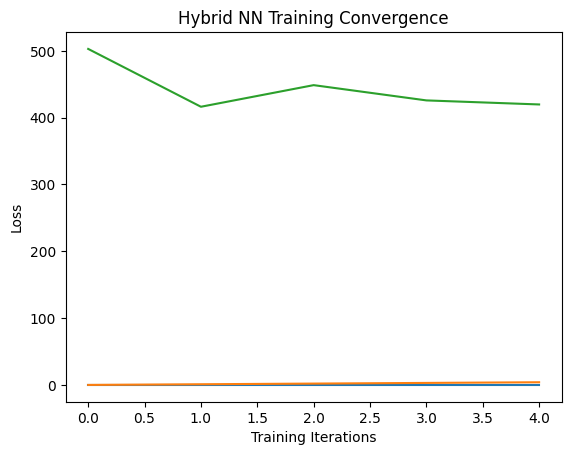

In [19]:
# Step 13 - Plot Prior Losses
print("Completed Epochs", training_stats[0], "Accuracy", training_stats[1])
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

In [20]:
# Define model, optimizer, and loss function
start_time = datetime.now()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = LOSS_FUNC

# Start training
epochs = EPOCHS  # Set number of epochs
model.train()  # Set model to training mode
# m = Softmax(dim=3)

print(DATASET, QUBITS, "Qubits, ", training_stats[0], "prior epochs, ", "Accuracy", '{0:.1f}%'.format(training_stats[1]), "Epochs", EPOCHS, "Batch Size:", BATCH_SIZE)
for epoch in range(epochs):
    for batch_idx in range(73):
      imgs_batch, res_batch, real_batch = dataset.minibatch(BATCH_SIZE)
      # for batch_idx, (data, target) in enumerate(train_loader):
      if(resume_stats[0] > epoch or (resume_stats[0] == epoch and resume_stats[1] >= batch_idx)):
        print(epoch, batch_idx, "already processed")
        continue
      optimizer.zero_grad(set_to_none=True)  # Initialize gradient
      if(DEBUG):
        print("epoch", epoch, "batch", batch_idx)
      # print("indexes", batch_idx*BATCH_SIZE, batch_idx*BATCH_SIZE+BATCH_SIZE)
      # features = train_features[batch_idx*BATCH_SIZE:batch_idx*BATCH_SIZE+BATCH_SIZE, :, :, :]
      # print("features", features[0, :, 0, 0])
      # print("x", x[0, :, 0, 0])
      data = torch.from_numpy(imgs_batch).to(device)
      target = torch.from_numpy(res_batch[:, NEURONS_FROM:NEURONS_FROM+NEURONS_PREDICTED]).to(device)
      # print("target", target.shape)

      def closure():
          optimizer.zero_grad()
          output = model(data)
          loss = loss_func(output, target)
          print(epoch, batch_idx, "output", output[0].cpu().detach().numpy(), "target", target[0].cpu().detach().numpy(), "loss", loss.item())
          loss_list.append([epoch, batch_idx, loss.item()])
          loss.backward()
          return loss

      optimizer.step(closure)  # Optimize weights
      resume_stats[0] = epoch
      resume_stats[1] = batch_idx
      torch.save(loss_list, f"checkpoints/{FILENAME_PREFIX}-losslist.pt")
      torch.save(model.state_dict(), f'checkpoints/{FILENAME_PREFIX}-modelweights.pt')
      torch.save(resume_stats, f"checkpoints/{FILENAME_PREFIX}-trainresumestats.pt")
      if(SAMPLE_RUN == True and batch_idx >= SAMPLE_ITERATIONS):
        break
    end_time = datetime.now()
    elapsed = end_time - start_time
    training_stats[0] = training_stats[0] + 1
    if(len(training_stats)<3):
      training_stats.append(0)
    training_stats[2] = training_stats[2] + elapsed.total_seconds()
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1][2]), "Elapsed", elapsed.total_seconds(), "total elapsed", training_stats[2])

    torch.save(model.state_dict(), f'checkpoints/{FILENAME_PREFIX}-modelweights-{epoch}.pt')


cadena 2 Qubits,  0 prior epochs,  Accuracy 0.0% Epochs 20 Batch Size: 256
0 0 already processed
0 1 already processed
0 2 already processed
0 3 already processed
0 4 already processed
0 5 output [0.60523415] target [3.] loss 511.918701171875
0 6 output [0.73951995] target [0.] loss 466.74029541015625
0 7 output [2.6964831] target [2.] loss 433.8669738769531
0 8 output [2.0842524] target [2.] loss 445.520263671875
0 9 output [1.4553885] target [1.] loss 421.4096374511719
0 10 output [2.1163757] target [1.] loss 407.0358581542969
0 11 output [0.0973852] target [0.] loss 396.61358642578125
0 12 output [0.04529984] target [1.] loss 391.80877685546875
0 13 output [0.10771856] target [2.] loss 399.47711181640625
0 14 output [2.5598915] target [1.] loss 408.01116943359375
0 15 output [2.1877327] target [0.] loss 419.4415283203125
0 16 output [0.1561376] target [0.] loss 393.45147705078125
0 17 output [1.1333872] target [3.] loss 413.58599853515625
0 18 output [2.0893846] target [5.] loss 470

In [21]:
# Step 15 - Plot loss convergence
plt.plot(loss_list[:, 2])
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [ ]:
# Step 16 - Load model for evaluation

qnn = create_qnn()
if DATASET == "blahblahblah":
  model = CifarNet(qnn4)
else:
  model = Net(qnn4)
model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-modelweights.pt'))

In [ ]:
# Step 18 - Predict

model.eval()  # set model to evaluation mode
with no_grad():
  correct = 0
  total = 0
  print("Testing Set size:", len(test_loader.dataset), "Batch Size:", BATCH_SIZE, "Number of batches:", (len(test_loader.dataset)//BATCH_SIZE)+1)

  for batch_idx, (data, target) in enumerate(test_loader):
    # if(batch_idx == 12):
    #   break
    features = test_features[batch_idx*BATCH_SIZE:batch_idx*BATCH_SIZE+BATCH_SIZE, :, :, :]
    if(features.shape[0] == 0):
      break
    output = model(features)
    # print("prediction output", output)
    print(total, end=" ")
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)

    pred = output.argmax(dim=1, keepdim=True)
    total += pred.shape[0]
    correct += pred.eq(target.view_as(pred)).sum().item()

    loss = loss_func(output, target)
    total_loss.append(loss.item())

  print(
      "Performance on test data:\n\tLoss: {:.4f}\n\tDataset: {}, Classes: {}, Features: {}, Qubits: {}, Epochs: {} New Epochs: {}\n\tAccuracy: {:.1f}% to {:.1f}%".format(
          sum(total_loss) / len(total_loss), DATASET,
          CLASSES, TOTAL_FEATURES, QUBITS, training_stats[0], EPOCHS,
          training_stats[1], correct * 100 / total
      )
  )
  training_stats[1] = correct * 100 / total

  torch.save(training_stats, f"checkpoints/{FILENAME_PREFIX}-trainingstats.pt")


In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table